C:\Users\THINKPAD\AppData\Local\Temp\ipykernel_8976\1179912048.py:51: Pandas4Warning: Sorting by default when concatenating all DatetimeIndex is deprecated.  In the future, pandas will respect the default of `sort=False`. Specify `sort=True` or `sort=False` to silence this message. If you see this warnings when not directly calling concat, report a bug to pandas.
  prices_df = pd.concat([tsla_forecast, spy_prices, bnd_prices], axis=1)


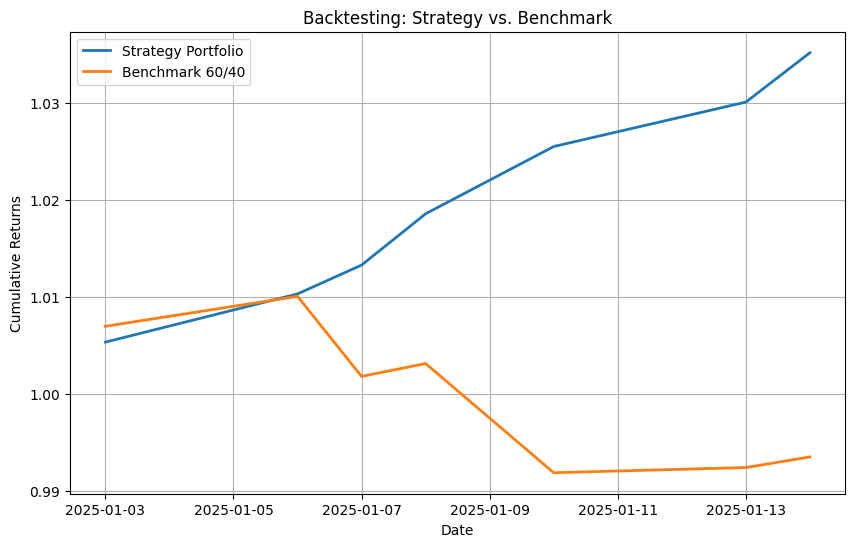

           Total Return  Annualized Return  Sharpe Ratio  Max Drawdown
Strategy       0.035220           2.476712     68.316661      0.000000
Benchmark     -0.006473          -0.208482     -2.242187     -0.018013

Strategy outperformed the benchmark in this backtest period.

Limitations: Short backtesting window, no transaction costs, no slippage, static weights assumed.


In [ ]:

# Task 5: Strategy Backtesting 


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# File paths
# -----------------------------
base_dir = r"C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\raw"
spy_path = os.path.join(base_dir, "SPY_historical.csv")
bnd_path = os.path.join(base_dir, "BND_historical.csv")


columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']


# Load Historical Data
spy_prices = pd.read_csv(
    spy_path,
    skiprows=2,
    names=columns,
    parse_dates=['Date'],
    index_col='Date'
)['Close']

bnd_prices = pd.read_csv(
    bnd_path,
    skiprows=2,
    names=columns,
    parse_dates=['Date'],
    index_col='Date'
)['Close']

# TSLA Forecast (example)
forecast_dates = pd.date_range(start='2025-01-01', periods=10, freq='B')
forecast_values = np.linspace(700, 750, len(forecast_dates))
tsla_forecast = pd.Series(forecast_values, index=forecast_dates, name='TSLA')

# Combine into prices DataFrame
prices_df = pd.concat([tsla_forecast, spy_prices, bnd_prices], axis=1)
prices_df.columns = ['TSLA', 'SPY', 'BND']
prices_df = prices_df.dropna()

# Backtesting Period
backtest_start = '2025-01-01'
backtest_end = '2026-01-01'
prices_bt = prices_df.loc[backtest_start:backtest_end]

# Strategy Portfolio (Max Sharpe)
strategy_weights = {'TSLA': 0.62052, 'SPY': 0.06946, 'BND': 0.31003}
weights_array = np.array([strategy_weights[col] for col in prices_bt.columns])

# Daily returns
daily_returns = prices_bt.pct_change().dropna()
strategy_returns = (daily_returns * weights_array).sum(axis=1)

# Benchmark Portfolio 60% SPY / 40% BND
benchmark_weights = np.array([0, 0.6, 0.4])
benchmark_returns = (daily_returns * benchmark_weights).sum(axis=1)

# Cumulative Returns
strategy_cum = (1 + strategy_returns).cumprod()
benchmark_cum = (1 + benchmark_returns).cumprod()

plt.figure(figsize=(10,6))
plt.plot(strategy_cum, label="Strategy Portfolio", linewidth=2)
plt.plot(benchmark_cum, label="Benchmark 60/40", linewidth=2)
plt.title("Backtesting: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend()
plt.grid(True)
plt.show()

# Performance Metrics
def performance_metrics(returns, trading_days=252):
    total_return = (1 + returns).prod() - 1
    annualized_return = (1 + total_return) ** (trading_days / len(returns)) - 1
    sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(trading_days)
    drawdown = (1 + returns).cumprod()
    max_drawdown = (drawdown / drawdown.cummax() - 1).min()
    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown
    }

strategy_metrics = performance_metrics(strategy_returns)
benchmark_metrics = performance_metrics(benchmark_returns)

metrics_df = pd.DataFrame([strategy_metrics, benchmark_metrics], index=['Strategy', 'Benchmark'])
print(metrics_df)

# Simple Reflection
if strategy_metrics['Annualized Return'] > benchmark_metrics['Annualized Return']:
    print("\nStrategy outperformed the benchmark in this backtest period.")
else:
    print("\nStrategy did NOT outperform the benchmark in this backtest period.")

print("\nLimitations: Short backtesting window, no transaction costs, no slippage, static weights assumed.")
